In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import PIL
import read_datasets as rd

from importlib import reload
import torchvision.transforms as transforms


import base64
import pickle
import collections
import itertools, collections
from sklearn.metrics import mean_squared_error
import cv2 
import math

In [2]:
import primitive_selector as ps
reload(ps)

<module 'primitive_selector' from '/home/xiaoyuz1/amazon_turk/primitive_selector.py'>

In [3]:
import torch.nn.utils.rnn as rnn
import torch

In [4]:
np.set_printoptions(precision=4, suppress=True)

In [5]:
dfo = pd.read_csv('/raid/xiaoyuz1/amazon_turk/df_all.csv')
dfo['no_punc_1'] = dfo.no_punc_1.apply(lambda x: [str(y).strip()[1:-1] for y in x[1:-1].split(',')])

dfp = pd.read_csv('/raid/xiaoyuz1/amazon_turk/df_all_pair.csv')
dfp['no_punc_1'] = dfp.no_punc_1.apply(lambda x: [str(y).strip()[1:-1] for y in x[1:-1].split(',')])
dfp['no_punc_2'] = dfp.no_punc_2.apply(lambda x: [str(y).strip()[1:-1] for y in x[1:-1].split(',')])

## CNN

In [ ]:
import sys    
path_to_module = '/home/xiaoyuz1/DoodlerGAN'
sys.path.append(path_to_module)

## use pretrained word features

In [ ]:
import clip
device = "cuda:3"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False) #Must set jit=False for training

In [ ]:
root_folder = '/raid/xiaoyuz1/clip_model_checkpoint'
torch_path_name = os.path.join(root_folder, "pleasant-tree-10.pt")
checkpoint = torch.load(torch_path_name)
print(checkpoint.keys())
args = checkpoint['args']

model.load_state_dict(checkpoint['model_state_dict'])

## test out primitive selector

In [ ]:
import sys
sys.argv = ['']
args = ps.get_args()

In [ ]:
args.use_image = True

In [ ]:
hp = ps.HParams()
args_dict = vars(args)
for k,v in args_dict.items():
    if k == "parameter_names":
        for j,name in enumerate(v):
            hp.parameter_names[j] = name
        continue
    if hasattr(hp, k):
        setattr(hp, k,v)
vocab = ps.preprocess_dataset_language(
    "/raid/xiaoyuz1/primitive_selector_training_data/july_15_train.pkl", old = True,
)
hp.vocab_size = len(vocab)

In [ ]:
TEMPLATE_DICT = {
    'arc' : lambda n : rd.generate_arc(n1=n, radius=1, x0=0, y0=0, template_size=1),
    'circle' : lambda n : rd.generate_circle(n1=n, radius=1, x0=0, y0=0, template_size=1),
    'square' : lambda n : rd.generate_square(n1=n, template_size=2),
    'semicircle' : lambda n : rd.generate_semicircle(n1=n, radius=1, x0=0, y0=0, template_size=1),
    'zigzag1' : lambda n : rd.generate_zigzag(n1=n, num_fold=1, side_length=1,template_size=1),
}
templates = {}
for i,(k,v) in enumerate(TEMPLATE_DICT.items()):
    arr = v(args.num_sampled_points)
    templates[i] = (k,arr)

In [ ]:
img_root_path = "/raid/xiaoyuz1/doodler_primitive_data/"

In [ ]:
reload(rd)
reload(ps)

In [ ]:
# .iloc[list(dfo[dfo["image_1"] == 0].index)]
all_data_path = "/raid/xiaoyuz1/primitive_selector_training_data/jul_20"
data = ps.prepare_data(dfo, \
                       templates, img_root_path, \
                       save_path_prefix = all_data_path, \
                       line_diameter=3, \
                       canvas_size = 64, num_sampled_points = 200, use_projective = False)

In [ ]:
arr = PIL.Image.open("/home/xiaoyuz1/testii.png")
plt.imshow(arr,cmap='Greys')
plt.show()

In [ ]:
for info in [data[i] for i in list(np.random.choice(11150, 10))]:
    print(info["raw"], info["part"], info["image_idx"])
    _ = rd.render_img(
        info["previous_strokes"] + [info["result"]], 
        img_path=None, 
        show=True,
        side=64,
        line_diameter=3,
        padding=0,
        bg_color=(0,0,0),
        fg_color=(1,1,1),
        original_side = 64.,
        invert = False,
    )

In [ ]:
def plot_prepared_data(info, num_sampled_points = 200, use_projective=False):
    w = h = 64
    fig, axs = plt.subplots(2, 1, figsize=(12,24)) 
    
    template = templates[info['primitive_type']][1]
    transform_mat = ps.get_affine_transformation(info)
    
    if use_projective:
        result = cv2.perspectiveTransform(template, transform_mat).reshape(-1,2)
    else:
        result = cv2.transform(np.array([template]).astype(np.float32), transform_mat)[0][:,:-1]
    axs[0].scatter(result[:,0], result[:,1], s=1, c='r')
    
#     theta, scale_mat, shear_mat = rd.decompose_affine(transform_mat)
#     T_rotate = rd.get_rotation_matrix(theta)
#     T_scale = rd.get_scale_matrix(scale_mat[0][0], scale_mat[1][1])
#     T_shear = rd.get_shear_matrix(shear_mat[0][1], shear_mat[1][0])
#     tx,ty = transform_mat[0][2],transform_mat[1][2]
#     T_translate = rd.get_translation_matrix(tx,ty)
    
#     result1 = cv2.transform(np.array([template]).astype(
#             np.float32), T_rotate)[0][:,:-1]
#     axs[0].scatter(result1[:,0], result1[:,1], s=1, c='m')
    
#     result2 = cv2.transform(np.array([template]).astype(
#             np.float32), T_rotate @ T_scale @ T_shear)[0][:,:-1]
#     axs[0].scatter(result2[:,0], result2[:,1], s=1, alpha=0.5, c='pink')

#     result3 = cv2.transform(np.array([template]).astype(
#             np.float32), T_translate @ T_rotate @ T_scale @ T_shear)[0][:,:-1]
#     axs[0].scatter(result3[:,0], result3[:,1], s=1, c='lime', alpha=0.5)
    
    axs[0].scatter(info["data"][:,0], info["data"][:,1], s=1, c='lime')

    axs[0].axis(xmin=-w,xmax=w)
    axs[0].axis(ymin=h,ymax=-h)
    axs[1].axis(xmin=-w,xmax=w)
    axs[1].axis(ymin=h,ymax=-h)

    
    
    plt.show()

In [ ]:
plot_prepared_data(info)

---

In [ ]:
checkpoint = torch.load('/raid/xiaoyuz1/doodler_model_checkpoint/legendary-sun-11/55001.pt')

In [ ]:
len(vocab)

In [ ]:
hp.M = 10

trainer = ps.Trainer(hp, args, vocab, templates)
trainer.model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
checkpoint['iteration']

In [ ]:
trainer.model.eval()
torch.no_grad()

In [ ]:
for batch_idx, (description_ts, primitive_types, affine_paramss, dataset_indices) in \
    enumerate(trainer.test_dataset_loader):
    if batch_idx == 4:
        break

In [ ]:
for ii, descr in enumerate(description_ts):
    desc_str = " ".join([trainer.train_dataset.vocab_reverse[j.item()] for j in descr])
    print(batch_idx, ii, dataset_indices[ii].item(), desc_str)

In [ ]:
description_ts_packed = rnn.pack_sequence(description_ts)                     
description_ts_packed, primitive_types, affine_paramss = \
    description_ts_packed.to(trainer.device), primitive_types.to(trainer.device), affine_paramss.to(trainer.device)

prim_pred, normal_dists, pi_dists = trainer.model(description_ts_packed)
prim_types = torch.argmax(prim_pred, dim=1)

In [ ]:
param_samples = trainer.sample_parameters(normal_dists, pi_dists)

In [ ]:
fig, _ = trainer.calculate_metric(description_ts, dataset_indices, prim_types, param_samples, \
                                  plot_indices=None, train=False, plot=True)

In [ ]:
idx = 29
train = False

In [ ]:
description_tensor = description_ts[idx]
data_idx = dataset_indices[idx].item()
prim_type = prim_types[idx].item()
pred_params = [sample[idx].item() for sample in param_samples]
if train:
    info = trainer.train_dataset.data_raw[data_idx]
else:
    info = trainer.test_dataset.data_raw[data_idx]

pred_template_name, pred_template = trainer.templates[int(prim_type)]
gt_template_name,_ = trainer.templates[int(info["primitive_type"])]
if train:
    data, gt_template, gt_fitted_template, gt_img = trainer.train_sequences[data_idx]
else:
    data, gt_template, gt_fitted_template, gt_img = trainer.test_sequences[data_idx]
gt_params = [info[trainer.hp.parameter_names[pi]] for pi in range(len(trainer.hp.parameter_names))]

pred_info = {}
for pi in range(len(trainer.hp.parameter_names)):
    pred_info[trainer.hp.parameter_names[pi]] = pred_params[pi]
pred_M = ps.GET_AFFINE_FUNCS["get_affine_transformation"](pred_info)

if trainer.args.use_projective:
    pred_template_pred_param = cv2.perspectiveTransform(pred_template, pred_M).reshape(-1,2)
else:
    pred_template_pred_param = cv2.transform(np.array([pred_template]).astype(np.float32), pred_M)[0][:,:-1]

# gt_img = np.asarray(rd.render_img([gt_fitted_template], line_diameter=3))
pred_img = np.asarray(rd.render_img([pred_template_pred_param], line_diameter=3))


In [ ]:
from sklearn.neighbors import NearestNeighbors

x,y = data, gt_fitted_template
x_nn = NearestNeighbors(n_neighbors=1, leaf_size=1, algorithm='kd_tree', metric='l2').fit(x)
min_y_to_x = x_nn.kneighbors(y)[0]
y_nn = NearestNeighbors(n_neighbors=1, leaf_size=1, algorithm='kd_tree', metric='l2').fit(y)
min_x_to_y = y_nn.kneighbors(x)[0]
dist_y_to_x = np.mean(min_y_to_x)
dist_x_to_y = np.mean(min_x_to_y)

In [ ]:
torch.set_printoptions(edgeitems=3)
for param_idx,(normal_dist, pi_dist) in enumerate(zip(normal_dists, pi_dists)):
    mu = normal_dist.loc[idx].reshape(-1,).detach().cpu().numpy()
    sigma = normal_dist.scale[idx].reshape(-1,).detach().cpu().numpy()
    pi = pi_dist.probs[idx].reshape(-1,).detach().cpu().numpy()
    print("\n\t", trainer.hp.parameter_names[param_idx], "\n\t", mu, "\n\t",sigma,"\n\t", pi)

In [ ]:
def mod(a, n):
    return (a % n + n) % n

def diff_angle(targetA, sourceA):
    a = targetA - sourceA
    a = mod(a+np.pi, 2 * np.pi) - np.pi
    return a

np.degrees(diff_angle(pred_info["theta"], info["theta"]))

## fitting primitives

In [ ]:
reload(rd)

In [ ]:
w = h = 256


In [ ]:
b_spline_num_sampled_points = num_sampled_points = n = 200
use_projective = False

In [ ]:
templates = {}
template_dict_processed = {}
for i,(k,v) in enumerate(TEMPLATE_DICT.items()):
    arr = v(b_spline_num_sampled_points)
    template_dict_processed[k] = arr
    templates[i] = (k,arr)

In [ ]:
rd.plot_primitives(template_dict_processed,w=2, h=2,num_pngs_per_row = 1, row_figsize = 10, column_figsize = 10)

In [ ]:
with open("/raid/xiaoyuz1/primitive_selector_training_data/july_15_all.pkl", "wb+") as f:
    pickle.dump(all_data, f)

In [ ]:
for t in ["train", "dev", "test"]:
    data_split = [x for x in all_data if x["split"] == t]
    data_split_dict = dict(zip(range(len(data_split)), data_split))
    with open(f"/raid/xiaoyuz1/primitive_selector_training_data/july_15_{t}.pkl", "wb+") as f:
        pickle.dump(data_split, f)

In [6]:
all_data = pickle.load(open("/raid/xiaoyuz1/primitive_selector_training_data/jul_20_test.pkl", "rb"))
df = pd.DataFrame(all_data)

In [ ]:
all_data2 = pickle.load(open("/raid/xiaoyuz1/primitive_selector_training_data/july_15_all.pkl", "rb"))
all_data2 = all_data2["all"]
df2 = pd.DataFrame(all_data2)

In [ ]:
print(all_data.keys())

In [ ]:
all_data["all"][0].keys()

In [7]:
data_raw = all_data["all"]

In [8]:
gt_fitted_img = rd.render_img([data_raw[6]["result"]], side=64, line_diameter=3, original_side = 64, invert=False)
img1 = transforms.ToTensor()(gt_fitted_img).squeeze(0).numpy()

gt_fitted_img2 = rd.render_img([data_raw[2]["result"]], side=64, line_diameter=3, original_side = 64, invert=False)
img2 = transforms.ToTensor()(gt_fitted_img2).squeeze(0).numpy()

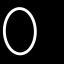

In [9]:
gt_fitted_img

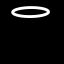

In [10]:
gt_fitted_img2

In [11]:
float_type = np.float64
im1 = img1.astype(float_type, copy=False)
im2 = img2.astype(float_type, copy=False)

In [12]:
from scipy.ndimage import uniform_filter
win_size = 7
ndim = im1.ndim
NP = win_size ** ndim
filter_func = uniform_filter
filter_args = {'size': win_size}
cov_norm = NP / (NP - 1)  # sample covariance

In [13]:
ux = filter_func(im1, **filter_args)
uy = filter_func(im2, **filter_args)

In [14]:
uxx = filter_func(im1 * im1, **filter_args)
uyy = filter_func(im2 * im2, **filter_args)
uxy = filter_func(im1 * im2, **filter_args)


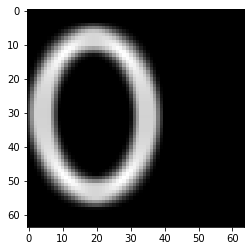

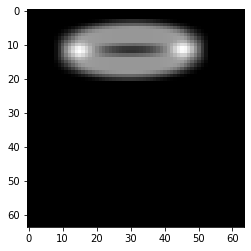

In [20]:
plt.imshow(ux, cmap="gray")
plt.show()
plt.imshow(uy, cmap="gray")
plt.show()
# plt.imshow(uxx, cmap="gray")
# plt.show()
# plt.imshow(uyy, cmap="gray")
# plt.show()
# plt.imshow(uxy, cmap="gray")
# plt.show()

In [16]:
vx = cov_norm * (uxx - ux * ux)
vy = cov_norm * (uyy - uy * uy)
vxy = cov_norm * (uxy - ux * uy)

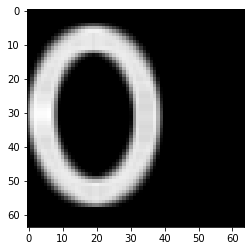

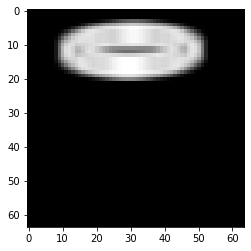

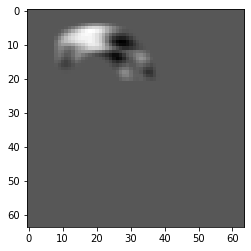

In [21]:
plt.imshow(vx, cmap="gray")
plt.show()
plt.imshow(vy, cmap="gray")
plt.show()
plt.imshow(vxy, cmap="gray")
plt.show()

In [18]:


K1 = 0.01
K2 = 0.03
    
R = 1
C1 = (K1 * R) ** 2
C2 = (K2 * R) ** 2
C3 = C2 * 0.5

A1, A2, B1, B2 = ((2 * ux * uy + C1,
                   2 * vxy + C2,
                   ux ** 2 + uy ** 2 + C1,
                   vx + vy + C2))
D = B1 * B2
S = (A1 * A2) / D

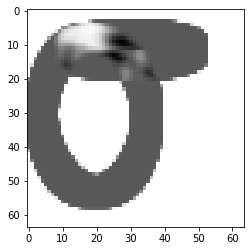

In [19]:
plt.imshow(S, cmap="gray")
plt.show()

In [22]:
S.mean()

0.6046740605275224

In [ ]:
lum_cmp = (2 * ux * uy + C1) / (ux ** 2 + uy ** 2 + C1)
contrast_cmp = (2 * uxx * uyy + C2) / (vx + vy + C2)
struct_cmp = (vxy + C3) / (ux * uy + C3)
plt.imshow(lum_cmp)
plt.show()
plt.imshow(contrast_cmp)
plt.show()
plt.imshow(struct_cmp)
plt.show()

In [ ]:
S.mean()

In [23]:
from skimage.metrics import structural_similarity 

ssim = structural_similarity(img1, img2, multichannel=False, data_range=1)
print(ssim)

0.5430466305007041


In [ ]:
img = transforms.Compose([transforms.ToTensor()])(PIL.Image.open(info["image_path"]))

In [ ]:
torch.stack([img,img]).shape

### plot GMM

In [ ]:
M_all = np.asarray(df.M.to_list())

In [ ]:
from sklearn.mixture import GaussianMixture

X = np.asarray(df.sx.to_list()).reshape(-1, 1)
# M_all[:,0].reshape(-1, 1)
print(X.min(), X.max())

N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]


#------------------------------------------------------------
# Plot the results
#  We'll use three panels:
#   1) data + best-fit mixture
#   2) AIC and BIC vs number of components
#   3) probability that a point came from each component

fig = plt.figure(figsize=(15, 20))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)


# plot 1: data + best-fit mixture
ax = fig.add_subplot(311)
M_best = models[np.argmin(AIC)]

x = np.linspace(X.min(), X.max(), 1000)
logprob = M_best.score_samples(x.reshape(-1, 1))
responsibilities = M_best.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)
ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')


# plot 2: AIC and BIC
ax = fig.add_subplot(312)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc=2)


# plot 3: posterior probabilities for each component
ax = fig.add_subplot(313)

p = responsibilities
p = p[:, (1, 0, 2)]  # rearrange order so the plot looks better
p = p.cumsum(1).T

ax.fill_between(x, 0, p[0], color='gray', alpha=0.3)
ax.fill_between(x, p[0], p[1], color='gray', alpha=0.5)
ax.fill_between(x, p[1], 1, color='gray', alpha=0.7)
ax.set_xlim(-6, 6)
ax.set_ylim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$p({\rm class}|x)$')

ax.text(-5, 0.3, 'class 1', rotation='vertical')
ax.text(0, 0.5, 'class 2', rotation='vertical')
ax.text(3, 0.3, 'class 3', rotation='vertical')

plt.show()


In [ ]:
print(M_best.weights_)
print(M_best.means_)
print(M_best.covariances_)

### code

In [ ]:
df.iloc[110]

In [ ]:
plot_prepared_data(df.iloc[110])

In [ ]:
drawing_arr = ps.CONST.face_json['train_data']

In [ ]:
reload(rd)


In [ ]:
reload(rd)
from tqdm import tqdm

M_arr = collections.defaultdict(lambda : np.zeros(9))
M_name = collections.defaultdict(lambda : " ")
M_mse = collections.defaultdict(float)


for idx in tqdm(range(len(drawing_arr))):
# for idx in range(len(drawing_arr)):
#     print(idx)
    
    strokes_spline_fitted = rd.process_quickdraw_to_part_convex_hull(
        drawing_arr[idx],
        list(CONST.face_parts_idx_dict.keys()),
        b_spline_num_sampled_points=n,
    )

    for _, (part_type, sketch_data) in enumerate(strokes_spline_fitted.items()):
        
        mat, prim_name, prim_mse = rd.get_transform_smallest_mse(
            sketch_data, template_dict_processed, use_projective=use_projective,
        )
        M_arr[(idx, part_type)] = mat
        M_name[(idx, part_type)] = prim_name
        M_mse[(idx, part_type)] = prim_mse
        


In [ ]:
with open('/raid/xiaoyuz1/SPG_Face_Part_256_projective_{}_mse.pkl'.format(use_projective), "wb+") as f:
    pickle.dump((dict(M_arr), dict(M_name), dict(M_mse)), f)

In [ ]:
'/raid/xiaoyuz1/SPG_Face_Part_256_projective_{}_mse.pkl'.format(use_projective)

In [ ]:
line_dict = dict(filter(lambda x: x[1] == 'line', M_name.items()))
print(len(line_dict), line_dict)

In [ ]:
M_arr, M_name = None,None
M_mse = None
fname = '/raid/xiaoyuz1/SPG_Face_Part_256_projective_False_mse.pkl'
with open(fname, "rb") as f:
    M_arr, M_name, M_mse = pickle.load(f)

In [ ]:
mse_l = list(filter(lambda x: not math.isinf(x), list(M_mse.values())))
np.mean(mse_l)

In [ ]:
image_list = list(map(lambda x: int(x[0]), M_name.keys()))
stroke_list = list(map(lambda x: int(x[1]), M_name.keys()))
arr_list = list(M_arr.values())
name_list = list(M_name.values())
mse_list = list(M_mse.values())

data = {'image': image_list, 'stroke' : stroke_list, 'M' : arr_list, 'primitive' : name_list, 'mse' : mse_list}

for c_idx,c in enumerate(np.asarray(arr_list).T):
    if c_idx > 5:
        continue
    data['M{}'.format(str(c_idx))] = c

df = pd.DataFrame.from_dict(data)

In [ ]:
dfa = df[df.mse.apply(lambda x: not math.isinf(x))]

In [ ]:
dfa

In [ ]:
M_all = np.asarray(dfa.M.to_list())

---------------------------------------

In [ ]:
idx = 0
stroke_idx = 1

In [ ]:
 pen_lift_indices = np.where(drawing_raw[:,2] == 1)[0]+1
        pen_and_part = np.vsplit(drawing_raw[:,2:].astype(float), pen_lift_indices)

In [ ]:

rd.show_these_sketches(
    CONST.face_json,
    [idx], 
    [str(idx)], 
    [[]], 
    num_pngs_per_row = 6,
    row_figsize = 4,
    column_figsize = 4,
)



In [ ]:
strokes_spline_fitted = rd.process_quickdraw_to_part_convex_hull(
    drawing_arr[idx],
    list(CONST.face_parts_idx_dict.keys()),
    b_spline_num_sampled_points=n,
)

# strokes_spline_fitted = rd.process_quickdraw_to_stroke_no_normalize(
#     drawing_arr[idx], 
#     b_spline_num_sampled_points=200,
# )
# print(len(strokes_spline_fitted))

In [ ]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

parts_indices = list(CONST.face_parts_idx_dict.keys())

drawing_raw = np.asarray(drawing_arr[idx])
drawing_raw[:,0] = np.cumsum(drawing_raw[:,0], 0) + 25
drawing_raw[:,1] = np.cumsum(drawing_raw[:,1], 0) + 25

parts = []
part_idx_part = {}

for k in parts_indices:
    strokes = drawing_raw[drawing_raw[:,-1] == k]
    if len(strokes) < 1:
        continue
    parts.append(strokes)
    part_idx_part[k] = strokes[:,:2]

In [ ]:
M_arr_idx, M_name_idx, M_mse_idx = {},{},{}
for stroke_index, (part_type, data) in enumerate(strokes_spline_fitted.items()):
        
    mat, prim_name, prim_mse = rd.get_transform_smallest_mse(
        data, template_dict_processed, use_projective=use_projective,
    )
    M_arr_idx[(idx, part_type)] = mat
    M_name_idx[(idx, part_type)] = prim_name
    M_mse_idx[(idx, part_type)] = prim_mse

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for k, M in M_arr_idx.items():
#     if k[1] != 3:
#         continue
    data = strokes_spline_fitted[k[1]]
    
    template = template_dict_processed[M_name_idx[(idx, k[1])]]
    Mm = M.reshape(3,3)
    
    result, mse = rd.get_transformed_template(template, data, Mm,projective=use_projective)
    ax1.scatter(result[:,0], result[:,1], label="transformed template", s=1, c='r')
    ax2.scatter(data[:,0], data[:,1], label="data", alpha=0.5, s=1, c='g')

# plt.legend()
# plt.xlim(0,w)
# plt.ylim(h,0)


ax1.axis(xmin=0,xmax=w)
ax1.axis(ymin=h,ymax=0)

ax2.axis(xmin=0,xmax=w)
ax2.axis(ymin=h,ymax=0)

plt.show()

In [ ]:
M_arr_idx, M_name_idx, M_mse_idx

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for index, entry in dfa[dfa.image == idx].iterrows():
    data = strokes_spline_fitted[entry.stroke]
    
    template_func = TEMPLATE_DICT[entry.primitive]
    template = template_func(n)
    
    print(entry.M.reshape(3,3))
    
    result, mse = rd.get_transformed_template(template, data, entry.M.reshape(3,3),projective=use_projective)
    ax1.scatter(result[:,0], result[:,1], label="transformed template", s=1, c='r')
    ax2.scatter(data[:,0], data[:,1], label="data", alpha=0.5, s=1, c='g')
    orig_data = part_idx_part[int(entry.stroke)]
    ax2.plot(orig_data[:,0], orig_data[:,1], alpha=0.5, c='b')
    
#     ax1.plot(result[:,0], result[:,1], label="transformed template", c='r')
#     ax2.plot(data[:,0], data[:,1], label="data", alpha=0.5,c='g')

# plt.legend()
# plt.xlim(0,w)
# plt.ylim(h,0)

ax1.axis(xmin=0,xmax=w)
ax1.axis(ymin=h,ymax=0)

ax2.axis(xmin=0,xmax=w)
ax2.axis(ymin=h,ymax=0)

plt.show()

## old icp code

In [ ]:
import cv2
import numpy as np
import sys
from numpy.random import *

In [ ]:
def del_miss(indeces, dist, max_dist, th_rate = 0.8):
    th_dist = max_dist * th_rate
    return np.array([indeces[0][np.where(dist.T[0] < th_dist)]])


In [ ]:
def is_converge(Tr, scale):
    delta_angle = 0.0001
    delta_scale = scale * 0.0001
    
    min_cos = 1 - delta_angle
    max_cos = 1 + delta_angle
    min_sin = -delta_angle
    max_sin = delta_angle
    min_move = -delta_scale
    max_move = delta_scale
    
    return min_cos < Tr[0, 0] and Tr[0, 0] < max_cos and \
           min_cos < Tr[1, 1] and Tr[1, 1] < max_cos and \
           min_sin < -Tr[1, 0] and -Tr[1, 0] < max_sin and \
           min_sin < Tr[0, 1] and Tr[0, 1] < max_sin and \
           min_move < Tr[0, 2] and Tr[0, 2] < max_move and \
           min_move < Tr[1, 2] and Tr[1, 2] < max_move

In [ ]:
def icp(d1, d2, max_iterate = 100):
    src = np.array([d1.T], copy=True).astype(np.float32)
    dst = np.array([d2.T], copy=True).astype(np.float32)
    
    knn = cv2.KNearest()
    responses = np.array(range(len(d2[0]))).astype(np.float32)
    knn.train(src[0], responses)
        
    Tr = np.array([[np.cos(0), -np.sin(0), 0],
                   [np.sin(0), np.cos(0),  0],
                   [0,         0,          1]])

    dst = cv2.transform(dst, Tr[0:2])
    max_dist = sys.maxint
    
    scale_x = np.max(d1[0]) - np.min(d1[0])
    scale_y = np.max(d1[1]) - np.min(d1[1])
    scale = max(scale_x, scale_y)
       
    for i in range(max_iterate):
        ret, results, neighbours, dist = knn.find_nearest(dst[0], 1)
        
        indeces = results.astype(np.int32).T     
        indeces = del_miss(indeces, dist, max_dist)  
        
        T = cv2.estimateRigidTransform(dst[0, indeces], src[0, indeces], True)

        max_dist = np.max(dist)
        dst = cv2.transform(dst, T)
        Tr = np.dot(np.vstack((T,[0,0,1])), Tr)
        
        if (is_converge(T, scale)):
            break
        
    return Tr[0:2]

In [ ]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    
    point_count = 100
    th = np.pi / 8
    move = np.array([[0.30], [0.5]])
    rnd_scale = 0.03
    x1 = np.linspace(0, 1.1, point_count)
    y1 = np.sin(x1 * np.pi)
    d1 = np.array([x1, y1])

    rot = np.array([[np.cos(th), -np.sin(th)], [np.sin(th), np.cos(th)]])
    rand = np.random.rand(2, point_count)*rnd_scale
    d2 = np.dot(rot, d1) + move
    d2 = np.add(d2, rand)

    plt.plot(d1[0], d1[1])
    plt.plot(d2[0], d2[1])
    plt.show()

In [ ]:
    ret = icp(d1, d2)
    
    plt.plot(d1[0], d1[1])
    dst = np.array([d2.T], copy=True).astype(np.float32)
    dst = cv2.transform(dst, ret)
    plt.plot(dst[0].T[0], dst[0].T[1])
    plt.show()
    
    print ret[0][0] * ret[0][0] + ret[0][1] * ret[0][1]
    print np.arccos(ret[0][0]) / 2 / np.pi * 360
    print np.arcsin(ret[0][1]) / 2 / np.pi * 360

    print ret

In [ ]:
def icp(a, b,
        max_time = 1
    ):
    import cv2
    import numpy
    import copy
    import pylab
    import time
    import sys
    import sklearn.neighbors
    import scipy.optimize



    def res(p,src,dst):
        T = numpy.matrix([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],
        [numpy.sin(p[2]), numpy.cos(p[2]),p[1]],
        [0 ,0 ,1 ]])
        n = numpy.size(src,0)
        xt = numpy.ones([n,3])
        xt[:,:-1] = src
        xt = (xt*T.T).A
        d = numpy.zeros(numpy.shape(src))
        d[:,0] = xt[:,0]-dst[:,0]
        d[:,1] = xt[:,1]-dst[:,1]
        r = numpy.sum(numpy.square(d[:,0])+numpy.square(d[:,1]))
        return r

    def jac(p,src,dst):
        T = numpy.matrix([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],
        [numpy.sin(p[2]), numpy.cos(p[2]),p[1]],
        [0 ,0 ,1 ]])
        n = numpy.size(src,0)
        xt = numpy.ones([n,3])
        xt[:,:-1] = src
        xt = (xt*T.T).A
        d = numpy.zeros(numpy.shape(src))
        d[:,0] = xt[:,0]-dst[:,0]
        d[:,1] = xt[:,1]-dst[:,1]
        dUdth_R = numpy.matrix([[-numpy.sin(p[2]),-numpy.cos(p[2])],
                            [ numpy.cos(p[2]),-numpy.sin(p[2])]])
        dUdth = (src*dUdth_R.T).A
        g = numpy.array([  numpy.sum(2*d[:,0]),
                        numpy.sum(2*d[:,1]),
                        numpy.sum(2*(d[:,0]*dUdth[:,0]+d[:,1]*dUdth[:,1])) ])
        return g
    
    def hess(p,src,dst):
        n = numpy.size(src,0)
        T = numpy.matrix([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],
        [numpy.sin(p[2]), numpy.cos(p[2]),p[1]],
        [0 ,0 ,1 ]])
        n = numpy.size(src,0)
        xt = numpy.ones([n,3])
        xt[:,:-1] = src
        xt = (xt*T.T).A
        d = numpy.zeros(numpy.shape(src))
        d[:,0] = xt[:,0]-dst[:,0]
        d[:,1] = xt[:,1]-dst[:,1]
        dUdth_R = numpy.matrix([[-numpy.sin(p[2]),-numpy.cos(p[2])],[numpy.cos(p[2]),-numpy.sin(p[2])]])
        dUdth = (src*dUdth_R.T).A
        H = numpy.zeros([3,3])
        H[0,0] = n*2
        H[0,2] = numpy.sum(2*dUdth[:,0])
        H[1,1] = n*2
        H[1,2] = numpy.sum(2*dUdth[:,1])
        H[2,0] = H[0,2]
        H[2,1] = H[1,2]
        d2Ud2th_R = numpy.matrix([[-numpy.cos(p[2]), numpy.sin(p[2])],[-numpy.sin(p[2]),-numpy.cos(p[2])]])
        d2Ud2th = (src*d2Ud2th_R.T).A
        H[2,2] = numpy.sum(2*(numpy.square(dUdth[:,0])+numpy.square(dUdth[:,1]) + d[:,0]*d2Ud2th[:,0]+d[:,0]*d2Ud2th[:,0]))
        return H
    
    
    t0 = time.time()
    init_pose = (0,0,0)
    src = numpy.array([a.T], copy=True).astype(numpy.float32)
    dst = numpy.array([b.T], copy=True).astype(numpy.float32)
    Tr = numpy.array([[numpy.cos(init_pose[2]),-numpy.sin(init_pose[2]),init_pose[0]],
                   [numpy.sin(init_pose[2]), numpy.cos(init_pose[2]),init_pose[1]],
                   [0,                    0,                   1          ]])
    print("src",numpy.shape(src))
    print("Tr[0:2]",numpy.shape(Tr[0:2]))
    src = cv2.transform(src, Tr[0:2])
    p_opt = numpy.array(init_pose)
    T_opt = numpy.array([])
    error_max = sys.maxsize
    first = False
    while not(first and time.time() - t0 > max_time):
        distances, indices = sklearn.neighbors.NearestNeighbors(n_neighbors=1, algorithm='auto',p = 3).fit(dst[0]).kneighbors(src[0])
        p = scipy.optimize.minimize(res,[0,0,0],args=(src[0],dst[0, indices.T][0]),method='Newton-CG',jac=jac,hess=hess).x
        T  = numpy.array([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],[numpy.sin(p[2]), numpy.cos(p[2]),p[1]]])
        p_opt[:2]  = (p_opt[:2]*numpy.matrix(T[:2,:2]).T).A       
        p_opt[0] += p[0]
        p_opt[1] += p[1]
        p_opt[2] += p[2]
        src = cv2.transform(src, T)
        Tr = (numpy.matrix(numpy.vstack((T,[0,0,1])))*numpy.matrix(Tr)).A
        error = res([0,0,0],src[0],dst[0, indices.T][0])

        if error < error_max:
            error_max = error
            first = True
            T_opt = Tr

    p_opt[2] = p_opt[2] % (2*numpy.pi)
    return T_opt, error_max


def main():
    import cv2
    import numpy
    import random
    import matplotlib.pyplot
    n1 = 100
    n2 = 75
    bruit = 1/10
    center = [random.random()*(2-1)*3,random.random()*(2-1)*3]
    radius = random.random()
    deformation = 2

    template = numpy.array([
        [numpy.cos(i*2*numpy.pi/n1)*radius*deformation for i in range(n1)], 
        [numpy.sin(i*2*numpy.pi/n1)*radius for i in range(n1)]
    ])

    data = numpy.array([
        [numpy.cos(i*2*numpy.pi/n2)*radius*(1+random.random()*bruit)+center[0] for i in range(n2)], 
        [numpy.sin(i*2*numpy.pi/n2)*radius*deformation*(1+random.random()*bruit)+center[1] for i in range(n2)]
    ])

    T,error = icp(data,template)
    dx = T[0,2]
    dy = T[1,2]
    rotation = numpy.arcsin(T[0,1]) * 360 / 2 / numpy.pi

    print("T",T)
    print("error",error)
    print("rotation°",rotation)
    print("dx",dx)
    print("dy",dy)

    result = cv2.transform(numpy.array([data.T], copy=True).astype(numpy.float32), T).T
    matplotlib.pyplot.plot(template[0], template[1], label="template")
    matplotlib.pyplot.plot(data[0], data[1], label="data")
    matplotlib.pyplot.plot(result[0], result[1], label="result: "+str(rotation)+"° - "+str([dx,dy]))
    matplotlib.pyplot.legend(loc="upper left")
    matplotlib.pyplot.axis('square')
    matplotlib.pyplot.show()

if __name__ == "__main__":
    main()